In [1]:
import os
from collections import Counter
import logging
import sys
from pathlib import Path
import subprocess
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import IPython
import pandas as pd
import boto3

from dotenv import load_dotenv

In [2]:
def find_comp_gen_dir():
    """Find the computational_genetic_genealogy directory by searching up from current directory."""
    current = Path.cwd()
    
    # Search up through parent directories
    while current != current.parent:
        # Check if target directory exists in current path
        target = current / 'computational_genetic_genealogy'
        if target.is_dir():
            return target
        # Move up one directory
        current = current.parent
    
    raise FileNotFoundError("Could not find computational_genetic_genealogy directory")

def load_env_file():
    """Find and load the .env file from the computational_genetic_genealogy directory."""
    try:
        # Find the computational_genetic_genealogy directory
        comp_gen_dir = find_comp_gen_dir()
        
        # Look for .env file
        env_path = comp_gen_dir / '.env'
        if not env_path.exists():
            print(f"Warning: No .env file found in {comp_gen_dir}")
            return None
        
        # Load the .env file
        load_dotenv(env_path, override=True)
        print(f"Loaded environment variables from: {env_path}")
        return env_path
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Use the function
env_path = load_env_file()

Loaded environment variables from: /home/lakishadavid/computational_genetic_genealogy/.env


In [3]:
working_directory = os.getenv('PROJECT_WORKING_DIR', default=None)
data_directory = os.getenv('PROJECT_DATA_DIR', default=None)
references_directory = os.getenv('PROJECT_REFERENCES_DIR', default=None)
results_directory = os.getenv('PROJECT_RESULTS_DIR', default=None)
utils_directory = os.getenv('PROJECT_UTILS_DIR', default=None)

print(f"Working Directory: {working_directory}")
print(f"Data Directory: {data_directory}")
print(f"References Directory: {references_directory}")
print(f"Results Directory: {results_directory}")
print(f"Utils Directory: {utils_directory}")

os.chdir(working_directory)
print(f"The current directory is {os.getcwd()}")

Working Directory: /home/lakishadavid/computational_genetic_genealogy
Data Directory: /home/lakishadavid/computational_genetic_genealogy/data
References Directory: /home/lakishadavid/computational_genetic_genealogy/references
Results Directory: /home/lakishadavid/computational_genetic_genealogy/results
Utils Directory: /home/lakishadavid/computational_genetic_genealogy/utils
The current directory is /home/lakishadavid/computational_genetic_genealogy


In [4]:
def configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO"):
    """
    Configure logging for both file and console handlers.

    Args:
        log_filename (str): Path to the log file where logs will be written.
        log_file_debug_level (str): Logging level for the file handler.
        console_debug_level (str): Logging level for the console handler.
    """
    # Create a root logger
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)  # Capture all messages at the root level

    # Convert level names to numeric levels
    file_level = getattr(logging, log_file_debug_level.upper(), logging.INFO)
    console_level = getattr(logging, console_debug_level.upper(), logging.INFO)

    # File handler: Logs messages at file_level and above to the file
    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(file_level)
    file_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(file_formatter)

    # Console handler: Logs messages at console_level and above to the console
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(console_level)
    console_formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(console_formatter)

    # Add handlers to the root logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
def clear_logger():
    """Remove all handlers from the root logger."""
    logger = logging.getLogger()
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

In [5]:
log_filename = os.path.join(results_directory, "lab8.log")
print(f"The Lab 8 log file is located at {log_filename}.")

# Ensure the results_directory exists
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Check if the file exists; if not, create it
if not os.path.exists(log_filename):
    with open(log_filename, 'w') as file:
        pass  # The file is now created.
    
clear_logger() # Clear the logger before reconfiguring it
configure_logging(log_filename, log_file_debug_level="INFO", console_debug_level="INFO")

The Lab 8 log file is located at /home/lakishadavid/computational_genetic_genealogy/results/lab8.log.


In [16]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Get the 1000 Genomes and merge with sample VCF

sample_directory=${results_directory}/onekgenomes_insample
mkdir -p "${sample_directory}"

for chr in {1..22}; do
    
    onekgenomes_samples="${references_directory}/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr${chr}.vcf.gz"
    phased_samples="${results_directory}/phased_samples/merged_opensnps_phased_chr${chr}_sorted.vcf.gz"
    output_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}_merged.vcf.gz"
    sorted_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}.vcf.gz"
    
    if [ -f "${onekgenomes_samples}" ]; then
        echo "Processing chromosome ${chr}..."
        bcftools merge -O z -o "${output_samples}" "${onekgenomes_samples}" "${phased_samples}"
 
        bcftools index -t "${output_samples}"
        bcftools sort -Oz -o "${sorted_samples}" "${output_samples}" || {
            echo "Sorting failed for chromosome $chr"
        }
        
        if [ -f "${sorted_samples}" ]; then
            bcftools index -t "${sorted_samples}"
            rm "${output_samples}"
            rm "${output_samples}.tbi"
            num_samples=$(bcftools query -l "${sorted_samples}" | wc -l)
            echo "${num_samples}"
        fi
        
    else
        echo "Skipping chromosome ${chr}: ${onekgenomes_samples} does not exist."
    fi
done

Processing chromosome 1...


Writing to /tmp/bcftools.doEog7
Merging 4 temporary files
Cleaning
Done


3320
Skipping chromosome 2: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr2.vcf.gz does not exist.
Skipping chromosome 3: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr3.vcf.gz does not exist.
Skipping chromosome 4: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr4.vcf.gz does not exist.
Skipping chromosome 5: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr5.vcf.gz does not exist.
Skipping chromosome 6: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr6.vcf.gz does not exist.
Skipping chromosome 7: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genoty

Writing to /tmp/bcftools.kbLmJg
Merging 2 temporary files
Cleaning
Done


3320
Skipping chromosome 21: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr21.vcf.gz does not exist.
Skipping chromosome 22: /home/lakishadavid/computational_genetic_genealogy/references/onethousandgenomes_genotype/onethousandgenomes_genotyped_phased.chr22.vcf.gz does not exist.


### Run the hap-IBD Detection Algorithm

In [19]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Define the hap-IBD executable path
hap_ibd="${utils_directory}/hap-ibd.jar"

# Ensure the hap-IBD executable exists
if [[ ! -f "${hap_ibd}" ]]; then
    echo "Error: Hap-IBD executable not found: ${hap_ibd}" >&2
    exit 1
fi

# Run hap-IBD analysis in loop by chromosome
for chr in {1..22}; do
    phased_samples="${results_directory}/onekgenomes_insample/sample_with_onekgenomes_chr${chr}.vcf.gz"
    
    if [[ -f "${phased_samples}" ]]; then
        echo "Running hap-IBD analysis for chromosome ${chr}..."

        java -jar "${hap_ibd}" gt="${phased_samples}" \
            map="${references_directory}/genetic_maps/beagle_genetic_maps/plink.chr${chr}.GRCh38.map" \
            out="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg" \
            nthreads=4
            
        if [[ $? -eq 0 ]]; then
            echo "hap-IBD analysis completed successfully for chromosome ${chr}."
        else
            echo "Error running hap-IBD analysis for chromosome ${chr}." >&2
            exit 1
        fi
    else
        echo "File not found: ${phased_samples}" >&2
        continue
    fi
done

Running hap-IBD analysis for chromosome 1...
Copyright (C) 2019-2023 Brian L. Browning
Enter "java -jar hap-ibd.jar" to print a list of command line arguments

Program            :  hap-ibd.jar  [ version 1.0, 15Jun23.92f ]
Start Time         :  07:21 AM CST on 22 Feb 2025
Max Memory         :  1948 MB

Parameters
  gt               :  /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr1.vcf.gz
  map              :  /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr1.GRCh38.map
  out              :  /home/lakishadavid/computational_genetic_genealogy/results/sample_with_onekgenomes_hapibd_chr1.seg
  min-seed         :  2.0
  max-gap          :  1000
  min-extend       :  1.0
  min-output       :  2.0
  min-markers      :  100
  min-mac          :  2
  nthreads         :  4

Statistics
  samples          :  3320
  markers          :  126776
  IBD segments     :  2664662
  IBD seg

File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr2.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr3.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr4.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr5.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr6.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr7.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr8.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/o

Running hap-IBD analysis for chromosome 20...
Copyright (C) 2019-2023 Brian L. Browning
Enter "java -jar hap-ibd.jar" to print a list of command line arguments

Program            :  hap-ibd.jar  [ version 1.0, 15Jun23.92f ]
Start Time         :  07:22 AM CST on 22 Feb 2025
Max Memory         :  1948 MB

Parameters
  gt               :  /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr20.vcf.gz
  map              :  /home/lakishadavid/computational_genetic_genealogy/references/genetic_maps/beagle_genetic_maps/plink.chr20.GRCh38.map
  out              :  /home/lakishadavid/computational_genetic_genealogy/results/sample_with_onekgenomes_hapibd_chr20.seg
  min-seed         :  2.0
  max-gap          :  1000
  min-extend       :  1.0
  min-output       :  2.0
  min-markers      :  100
  min-mac          :  2
  nthreads         :  4

Statistics
  samples          :  3320
  markers          :  37850
  IBD segments     :  37681
  IBD se

File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr21.vcf.gz
File not found: /home/lakishadavid/computational_genetic_genealogy/results/onekgenomes_insample/sample_with_onekgenomes_chr22.vcf.gz


In [20]:
%%bash -s "$data_directory" "$results_directory" "$utils_directory" "$references_directory"

data_directory="$1"
results_directory="$2"
utils_directory="$3"
references_directory="$4"

# Create or empty the merged output file
output_file="${results_directory}/sample_with_onekgenomes_autosomes_hapibd.seg"
: > "${output_file}"

# Merge chromosome files
for chr in {1..22}; do
    input_file="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg.ibd.gz"
    
    if [[ -f "${input_file}" ]]; then
        echo "Processing chromosome ${chr}..."
        zcat "${input_file}" >> "${output_file}"
    else
        echo "Warning: File for chromosome ${chr} not found during concatenation: ${input_file}" >&2
    fi
done

# Remove temporary files
for chr in {1..22}; do
    temp_file="${results_directory}/sample_with_onekgenomes_hapibd_chr${chr}.seg.ibd.gz"
    if [[ -f "${temp_file}" ]]; then
        rm -f "${temp_file}"
        echo "Removed temporary file for chromosome ${chr}"
    fi
done

echo "Processing complete. Merged file created at: ${output_file}"
echo "Note: HBD and log files still remain"

Processing chromosome 1...


Processing chromosome 20...


Removed temporary file for chromosome 1
Removed temporary file for chromosome 20
Processing complete. Merged file created at: /home/lakishadavid/computational_genetic_genealogy/results/sample_with_onekgenomes_autosomes_hapibd.seg
Note: HBD and log files still remain


### Explore The Segments Results

In [21]:
segments = os.path.join(results_directory, "sample_with_onekgenomes_autosomes_hapibd.seg")

segments_temp = pd.read_csv(segments, sep="\t", header=None)
segments_temp.columns = [
    "id1", "sample1_haplotype", "id2", "sample2_haplotype",
    "chrom", "phys_start_pos", "phys_end_pos", 
    "genetic_length"
    ]
segments = segments_temp.sort_values(
    by=["chrom", "phys_start_pos", "phys_end_pos"],
    ascending=[True, True, True]
)
segments = segments.reset_index(drop=True)
output_file = os.path.join(results_directory, "merged_opensnps_autosomes_hapibd.csv")
segments.to_csv(output_file, sep="\t", index=False, header=False)
segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702343 entries, 0 to 2702342
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id1                object 
 1   sample1_haplotype  int64  
 2   id2                object 
 3   sample2_haplotype  int64  
 4   chrom              int64  
 5   phys_start_pos     int64  
 6   phys_end_pos       int64  
 7   genetic_length     float64
dtypes: float64(1), int64(5), object(2)
memory usage: 164.9+ MB


In [22]:
segments.head() # You can enter a number greater than 5 to view more rows

id1  sample1_haplotype      id2  sample2_haplotype  chrom  \
0  HG02343                  1  HG02561                  2      1   
1  HG02343                  1  HG03455                  1      1   
2  HG02343                  1  HG03456                  2      1   
3  HG02343                  1  HG03578                  2      1   
4  HG02561                  2  HG03499                  2      1   

   phys_start_pos  phys_end_pos  genetic_length  
0          115746        945562            2.24  
1          115746        945562            2.24  
2          115746        945562            2.24  
3          115746        945562            2.24  
4          115746        945562            2.24

In [ ]:
import pandas as pd

# Load the sample and population files into Pandas DataFrames
sample_file_name = os.path.join(references_directory, "20140502_complete_sample_summary.txt")
try:
    sample_df = pd.read_csv(sample_file_name, sep='\t')
except FileNotFoundError as e:
    print(f"File not found: {e}")

print(sample_df.columns)

Index(['Sample', 'Family ID', 'Population', 'Population Description', 'Gender',
       'Relationship', 'Unexpected Parent/Child ', 'Non Paternity', 'Siblings',
       'Grandparents', 'Avuncular', 'Half Siblings', 'Unknown Second Order',
       'Third Order', 'Other Comments', 'In Low Coverage Pilot',
       'LC Pilot Platforms', 'LC Pilot Centers', 'In High Coverage Pilot',
       'HC Pilot Platforms', 'HC Pilot Centers', 'In Exon Targetted Pilot',
       'ET Pilot Platforms', 'ET Pilot Centers', 'Has Sequence in Phase1',
       'Phase1 LC Platform', 'Phase1 LC Centers', 'Phase1 E Platform',
       'Phase1 E Centers', 'In Phase1 Integrated Variant Set',
       'Has Phase1 chrY SNPS', 'Has phase1 chrY Deletions',
       'Has phase1 chrMT SNPs', 'Main project LC Centers',
       'Main project LC platform', 'Total LC Sequence',
       'LC Non Duplicated Aligned Coverage', 'Main Project E Centers',
       'Main Project  E Platform', 'Total Exome Sequence',
       '% Targets Covered to 20x 

In [43]:
def identify_project_samples(segments, sample_df):
    """Identify project samples that aren't in 1000 Genomes"""
    # Get unique sample IDs from IBD data
    all_samples = pd.unique(segments[['id1', 'id2']].values.ravel())
    
    # Identify project samples (those not in 1000 Genomes metadata)
    project_samples = set(all_samples) - set(sample_df['Sample'])
    
    print(f"Total unique samples in IBD data: {len(all_samples)}")
    print(f"Samples in 1000 Genomes: {len(sample_df['Sample'])}")
    print(f"Project samples identified: {len(project_samples)}")
    
    return list(project_samples)

project_samples = identify_project_samples(segments, sample_df)

# print("\nProject sample IDs:")
# print(project_samples)

Total unique samples in IBD data: 3320
Samples in 1000 Genomes: 3690
Project samples identified: 119


In [51]:
def calculate_tmrca(genetic_length, constant=50):
    """Calculate TMRCA in generations based on genetic length in cM"""
    return constant/genetic_length

def calculate_sharing_stats(sample_id, sample_df):
    """Calculate IBD sharing statistics with TMRCA estimates"""
    # Get all segments where this sample is either id1 or id2
    sample_segments = segments[(segments['id1'] == sample_id) | (segments['id2'] == sample_id)].copy()
    
    # Calculate TMRCA for each segment
    sample_segments['tmrca_generations'] = sample_segments['genetic_length'].apply(calculate_tmrca)
    sample_segments['tmrca_years'] = sample_segments['tmrca_generations'] * 25  # assuming 25 years per generation
    
    # For each segment, get the other sample ID
    sample_segments['other_id'] = np.where(
        sample_segments['id1'] == sample_id,
        sample_segments['id2'],
        sample_segments['id1']
    )
    
    # Merge with population information
    sharing_df = pd.merge(
        sample_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Calculate statistics by population
    stats_df = sharing_df.groupby(['Population', 'Population Description']).agg({
        'genetic_length': ['count', 'sum', 'mean', 'std'],
        'tmrca_generations': ['mean', 'min', 'max'],
        'tmrca_years': ['mean', 'min', 'max'],
        'other_id': 'nunique'
    }).round(2)
    
    # Flatten column names
    stats_df.columns = ['n_segments', 'total_length_cM', 'mean_length_cM', 'std_length_cM',
                       'mean_tmrca_gen', 'min_tmrca_gen', 'max_tmrca_gen',
                       'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years',
                       'n_individuals']
    
    # Reset index to make Population and Population Description regular columns
    stats_df = stats_df.reset_index()
    
    # Add sample ID column
    stats_df['sample_id'] = sample_id
    
    # Reorder columns
    cols = ['sample_id', 'Population', 'Population Description', 
            'n_segments', 'total_length_cM', 'mean_length_cM', 'std_length_cM',
            'mean_tmrca_gen', 'min_tmrca_gen', 'max_tmrca_gen',
            'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years',
            'n_individuals']
    stats_df = stats_df[cols]
    
    return stats_df

stats_df = calculate_sharing_stats('user1001', sample_df)
stats_df.head()

sample_id Population                             Population Description  \
0  user1001        ACB                      African Caribbean in Barbados   
1  user1001        ASW                   African Ancestry in Southwest US   
2  user1001        BEB                              Bengali in Bangladesh   
3  user1001        CDX                Chinese Dai in Xishuangbanna, China   
4  user1001        CEU  Utah residents with Northern and Western Europ...   

   n_segments  total_length_cM  mean_length_cM  std_length_cM  mean_tmrca_gen  \
0          71       372.470000        5.250000       0.390000        9.640000   
1          50       254.000000        5.080000       0.830000       10.380000   
2         120       546.430000        4.550000       1.300000       12.410000   
3          98       506.790000        5.170000       0.730000       10.030000   
4         308      1466.990000        4.760000       1.090000       11.460000   

   min_tmrca_gen  max_tmrca_gen  mean_tmrca_years  min_tmrca_years  \
0       8.960000      22.140000        241.030000       223.890000   
1       9.000000      22.610000        259.580000       225.100000   
2       8.320000      22.300000        310.200000       207.950000   
3       8.540000      21.540000        250.830000       213.530000   
4       6.610000      24.740000        286.420000       165.300000   

   max_tmrca_years  n_individuals  
0       553.590000             40  
1       565.360000             25  
2       557.540000             67  
3       538.560000             52  
4       618.510000            135

In [61]:
def create_sharing_heatmap(project_samples, sample_df):
   """Create a heatmap of IBD sharing and TMRCA between project samples and populations"""
   # Initialize results matrices with float dtype
   populations = sample_df['Population'].unique()
   sharing_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
   tmrca_gen_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
   tmrca_years_matrix = pd.DataFrame(0.0, index=project_samples, columns=populations, dtype=float)
   
   # Calculate sharing for each sample-population pair
   for sample in project_samples:
       pop_stats = calculate_sharing_stats(sample, sample_df)
       for _, row in pop_stats.iterrows():
           if pd.notna(row['Population']):
               sharing_matrix.loc[sample, row['Population']] = float(row['total_length_cM'])
               tmrca_gen_matrix.loc[sample, row['Population']] = float(row['mean_tmrca_gen'])
               tmrca_years_matrix.loc[sample, row['Population']] = float(row['mean_tmrca_years'])
   
   # Create figure with three subplots
   fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, len(project_samples) * 1.5))
   
   # Plot 1: Total IBD sharing
   sns.heatmap(sharing_matrix, cmap='YlOrRd', annot=True, fmt='.1f', ax=ax1)
   ax1.set_title('Total IBD sharing (cM) with 1000 Genomes populations')
   ax1.set_xlabel('1000 Genomes Population')
   ax1.set_ylabel('Project Samples')
   
   # Plot 2: Mean TMRCA in generations
   sns.heatmap(tmrca_gen_matrix, cmap='viridis', annot=True, fmt='.1f', ax=ax2)
   ax2.set_title('Mean TMRCA (generations) with 1000 Genomes populations')
   ax2.set_xlabel('1000 Genomes Population')
   ax2.set_ylabel('Project Samples')
   
   # Plot 3: Mean TMRCA in years
   sns.heatmap(tmrca_years_matrix, cmap='viridis', annot=True, fmt='.0f', ax=ax3)
   ax3.set_title('Mean TMRCA (years) with 1000 Genomes populations')
   ax3.set_xlabel('1000 Genomes Population')
   ax3.set_ylabel('Project Samples')
   
   plt.tight_layout()
   plt.show()
   
   return sharing_matrix, tmrca_gen_matrix, tmrca_years_matrix

In [59]:
def analyze_segment_distribution(project_samples, sample_df):
    """Analyze the distribution of IBD segment lengths and TMRCA"""
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Get project segments
    project_segments = segments[
        (segments['id1'].isin(project_samples)) | 
        (segments['id2'].isin(project_samples))
    ].copy()
    
    # Calculate TMRCA for segments
    project_segments['tmrca_generations'] = project_segments['genetic_length'].apply(lambda x: 50/x)
    project_segments['tmrca_years'] = project_segments['tmrca_generations'] * 25
    
    # Add population information
    project_segments['other_id'] = np.where(
        project_segments['id1'].isin(project_samples),
        project_segments['id2'],
        project_segments['id1']
    )
    
    merged_segments = pd.merge(
        project_segments,
        sample_df[['Sample', 'Population', 'Population Description']],
        left_on='other_id',
        right_on='Sample',
        how='left'
    )
    
    # Plot 1: Segment length distribution
    sns.histplot(data=merged_segments, x='genetic_length', bins=50, ax=ax1)
    ax1.set_title('Distribution of IBD segment lengths')
    ax1.set_xlabel('Segment length (cM)')
    
    # Plot 2: TMRCA distribution
    sns.histplot(data=merged_segments, x='tmrca_years', bins=50, ax=ax2)
    ax2.set_title('Distribution of TMRCA')
    ax2.set_xlabel('TMRCA (years)')
    
    # Plot 3: Box plot of segment lengths by population
    sns.boxplot(data=merged_segments, x='Population', y='genetic_length', ax=ax3)
    ax3.set_title('IBD segment lengths by population')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
    
    # Plot 4: Box plot of TMRCA by population
    sns.boxplot(data=merged_segments, x='Population', y='tmrca_years', ax=ax4)
    ax4.set_title('TMRCA by population')
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    return fig, merged_segments

In [60]:
def summarize_population_sharing(project_samples, sample_df):
    """Create a summary of IBD sharing and TMRCA with each population"""
    all_stats = []
    
    for sample in project_samples:
        pop_stats = calculate_sharing_stats(sample, sample_df)
        all_stats.append(pop_stats)
    
    # Combine all statistics
    summary_df = pd.concat(all_stats, ignore_index=True)
    
    # Create pivot table for easy viewing
    summary_pivot = pd.pivot_table(
        summary_df, 
        values=['total_length_cM', 'n_segments', 'mean_tmrca_years', 'min_tmrca_years', 'max_tmrca_years'],
        index='sample_id',
        columns='Population',
        aggfunc='first'
    )
    
    return summary_df, summary_pivot

Total unique samples in IBD data: 3320
Samples in 1000 Genomes: 3690
Project samples identified: 119


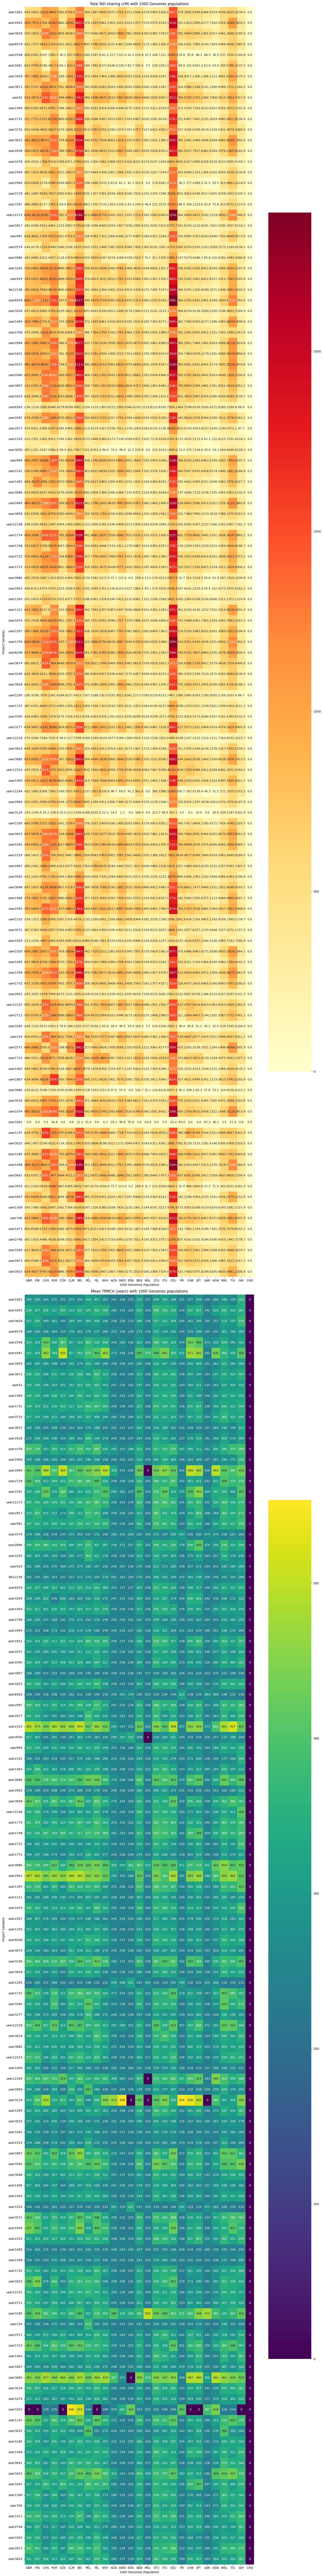

/tmp/ipykernel_692450/3152559567.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
/tmp/ipykernel_692450/3152559567.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)


Summary of sharing statistics:
  sample_id Population                             Population Description  \
0  user1001        ACB                      African Caribbean in Barbados   
1  user1001        ASW                   African Ancestry in Southwest US   
2  user1001        BEB                              Bengali in Bangladesh   
3  user1001        CDX                Chinese Dai in Xishuangbanna, China   
4  user1001        CEU  Utah residents with Northern and Western Europ...   

   n_segments  total_length_cM  mean_length_cM  std_length_cM  mean_tmrca_gen  \
0          71       372.470000        5.250000       0.390000        9.640000   
1          50       254.000000        5.080000       0.830000       10.380000   
2         120       546.430000        4.550000       1.300000       12.410000   
3          98       506.790000        5.170000       0.730000       10.030000   
4         308      1466.990000        4.760000       1.090000       11.460000   

   min_tmrca_gen  m

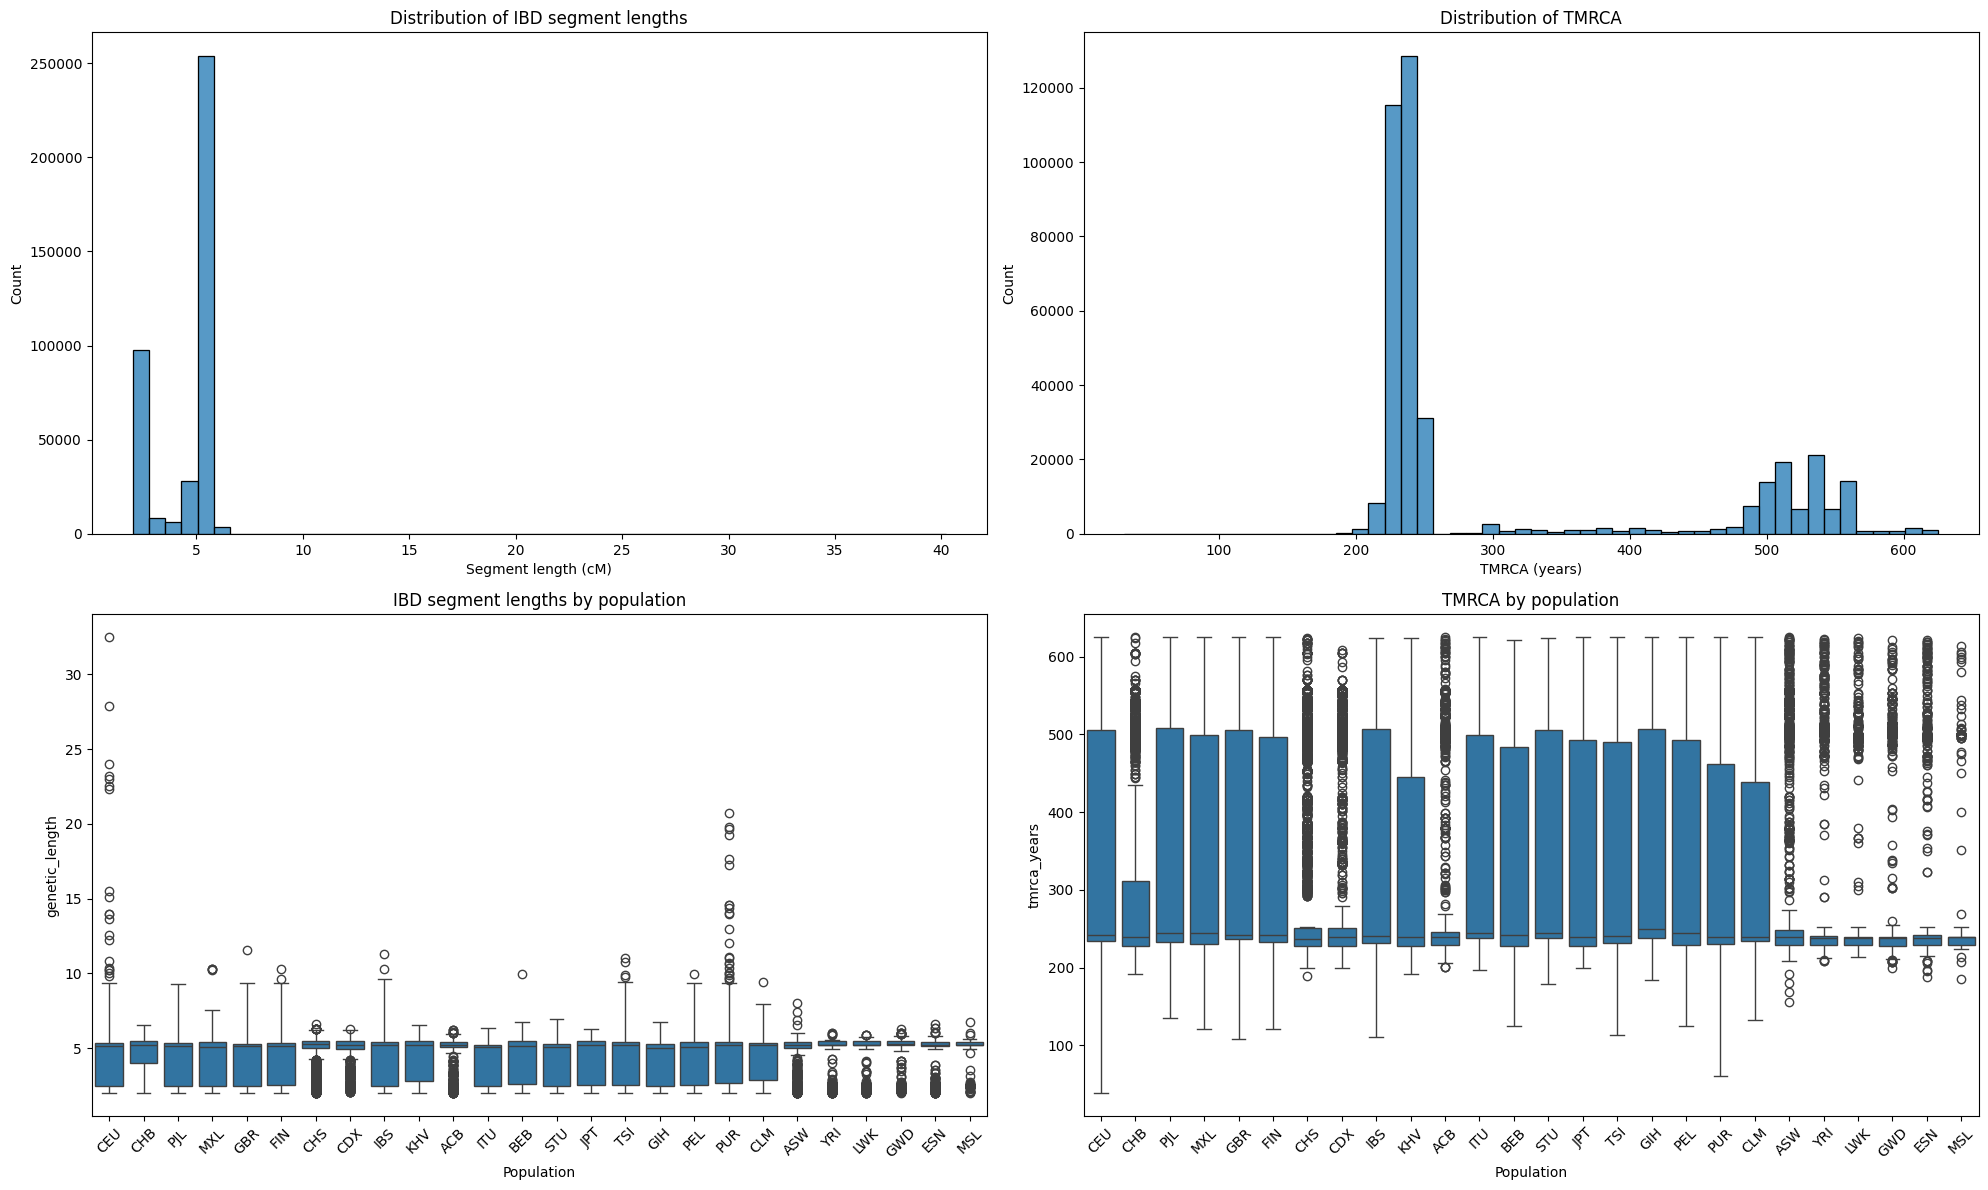

In [57]:
# First identify your project samples
project_samples = identify_project_samples(segments, sample_df)

# Create all visualizations and get summaries
# 1. Create heatmaps
sharing_matrix, tmrca_matrix = create_sharing_heatmap(project_samples, sample_df)

# 2. Analyze segment distributions and get merged segment data
distribution_fig, merged_segments = analyze_segment_distribution(project_samples, sample_df)

# 3. Get summary statistics
summary_df, summary_pivot = summarize_population_sharing(project_samples, sample_df)

# View the results
print("Summary of sharing statistics:")
print(summary_df.head())

print("\nPivot table view:")
print(summary_pivot.head())

# If you want to save any of the results:
# sharing_matrix.to_csv('sharing_matrix.csv')
# summary_df.to_csv('detailed_summary.csv')
# summary_pivot.to_csv('pivot_summary.csv')

# The figures will display automatically in Jupyter notebook
# If you want to save them:
# distribution_fig.savefig('segment_distribution.png', bbox_inches='tight', dpi=300)